In [1]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data'
ROOT_VAL_DATA_FOLDER = '../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_test_data'

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

## Parsing

In [18]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.stats as stats
from scipy.fft import fft, fftfreq

def parse_vibration_dataset(dataset_path):
    """
    Parsa il dataset di vibrazione e crea un DataFrame pandas con una riga per ogni file.
    Ogni riga contiene gli array completi delle serie temporali di vibrazione.

    Args:
        dataset_path (str): Percorso alla cartella principale del dataset

    Returns:
        pd.DataFrame: DataFrame con colonne etichetta, velocità, torque, rep e array di dati di vibrazione (una riga per file)
    """

    data_list = []
    
    # Prima passata: conta il numero totale di file .txt
    print("Conteggio file in corso...")
    total_files = 0
    for root, dirs, files in os.walk(dataset_path):
        total_files += sum(1 for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file .txt da processare")

    # Seconda passada: processa i file con progress bar
    with tqdm(total=total_files, desc="Parsing dataset", unit="file") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):
                    folder_name = os.path.basename(root)
                    if 'Pitting_degradation_level_' in folder_name:
                        etichetta_full = folder_name.replace('Pitting_degradation_level_', '')
                        if '(' in etichetta_full:
                            etichetta = etichetta_full.split('(')[0].strip()
                            descrizione = etichetta_full.split('(')[1].replace(')', '').strip()
                        else:
                            etichetta = etichetta_full.strip()
                            descrizione = None
                    else:
                        etichetta = folder_name
                        descrizione = None

                    # ERRORE CORRETTO: regex pattern per V100_200N_2.txt
                    pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                    match = re.search(pattern, file)

                    if match:
                        velocita = int(match.group(1))
                        torque = int(match.group(2))
                        rep = int(match.group(3))

                        file_path = os.path.join(root, file)
                        try:
                            # Carica tutti i dati del file una volta sola
                            data = np.loadtxt(file_path)
                            
                            # Calcola informazioni aggiuntive sui dati
                            sampling_rate = 20480  # Hz come specificato nella documentazione
                            duration = len(data) / sampling_rate
                            
                            # Crea un record per l'intero file
                            record = {
                                'file_name': file,
                                'etichetta': etichetta,
                                'health_level': int(etichetta) if etichetta.isdigit() else etichetta,
                                'velocita': velocita,
                                'torque': torque,
                                'rep': rep,
                                'horizontal_acceleration': data[:, 0],  # Array completo
                                'axial_acceleration': data[:, 1],       # Array completo
                                'vertical_acceleration': data[:, 2],    # Array completo
                                'tachometer_signal': data[:, 3],        # Array completo
                                'sampling_rate': sampling_rate,
                                'duration': duration,
                                'num_samples': len(data),
                                'descrizione': descrizione
                            }
                            # ERRORE CORRETTO: aggiungi record invece di data
                            data_list.append(record)

                        except Exception as e:
                            tqdm.write(f"Errore nel leggere il file {file_path}: {e}")
                            continue
                    else:
                        tqdm.write(f"Nome file non riconosciuto: {file}")
                    
                    # Aggiorna la progress bar
                    pbar.update(1)

    df = pd.DataFrame(data_list)

    if not df.empty:
        print("\nOrdinamento dataset...")
        df = df.sort_values(['health_level', 'velocita', 'torque', 'rep']).reset_index(drop=True)
        print(f"Dataset caricato: {len(df)} file processati")
        print(f"Health levels disponibili: {sorted(df['health_level'].unique())}")
        print(f"Condizioni operative (rpm): {sorted(df['velocita'].unique())}")
        print(f"Condizioni operative (torque): {sorted(df['torque'].unique())}")

    return df


def extract_signal_features(df, signal_column):
    """
    Estrae features statistiche e nel dominio della frequenza da una colonna di segnali.
    
    Args:
        df (pd.DataFrame): DataFrame con i dati
        signal_column (str): Nome della colonna contenente gli array dei segnali
    
    Returns:
        pd.DataFrame: DataFrame con features estratte
    """
    
    features_list = []
    
    # Progress bar per l'estrazione delle features
    with tqdm(total=len(df), desc=f"Estraendo features da {signal_column}", unit="segnale") as pbar:
        for idx, row in df.iterrows():
            signal = row[signal_column]
            
            # Features statistiche nel dominio del tempo
            features = {
                f'{signal_column}_mean': np.mean(signal),
                f'{signal_column}_std': np.std(signal),
                f'{signal_column}_rms': np.sqrt(np.mean(signal**2)),
                f'{signal_column}_peak': np.max(np.abs(signal)),
                f'{signal_column}_peak_to_peak': np.ptp(signal),
                f'{signal_column}_skewness': stats.skew(signal),
                f'{signal_column}_kurtosis': stats.kurtosis(signal),
                f'{signal_column}_crest_factor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2)),
            }
            
            # Features nel dominio della frequenza
            sampling_rate = row['sampling_rate']
            fft_vals = np.abs(fft(signal))
            freqs = fftfreq(len(signal), 1/sampling_rate)
            
            # Considera solo le frequenze positive
            positive_freq_idx = freqs > 0
            fft_positive = fft_vals[positive_freq_idx]
            freqs_positive = freqs[positive_freq_idx]
            
            # Trova la frequenza dominante
            dominant_freq_idx = np.argmax(fft_positive)
            features[f'{signal_column}_dominant_freq'] = freqs_positive[dominant_freq_idx]
            features[f'{signal_column}_dominant_magnitude'] = fft_positive[dominant_freq_idx]
            
            # Features spettrali
            total_power = np.sum(fft_positive**2)
            features[f'{signal_column}_spectral_centroid'] = np.sum(freqs_positive * fft_positive**2) / total_power
            features[f'{signal_column}_spectral_rolloff'] = freqs_positive[np.where(np.cumsum(fft_positive**2) >= 0.85 * total_power)[0][0]]
            
            features_list.append(features)
            pbar.update(1)
    
    return pd.DataFrame(features_list)


def extract_all_features(df):
    """
    Estrae tutte le features da tutti i segnali di accelerazione con progress bar complessiva.
    
    Args:
        df (pd.DataFrame): DataFrame con i dati grezzi
    
    Returns:
        pd.DataFrame: DataFrame completo con tutte le features
    """
    print("Iniziando estrazione features da tutti i segnali...")
    
    # Estrai features da tutti i segnali di accelerazione
    horizontal_features = extract_signal_features(df, 'horizontal_acceleration')
    axial_features = extract_signal_features(df, 'axial_acceleration')
    vertical_features = extract_signal_features(df, 'vertical_acceleration')

    print("Combinando tutte le features...")
    # Combina tutte le features
    features_df = pd.concat([
        df[['file_name', 'health_level', 'velocita', 'torque', 'rep']],
        horizontal_features,
        axial_features, 
        vertical_features
    ], axis=1)

    print(f"Features dataset completato! Shape: {features_df.shape}")
    return features_df


# Esempio di utilizzo:
# Carica il dataset
print("=== CARICAMENTO DATASET ===")
df = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER)

df.head()

=== CARICAMENTO DATASET ===
Conteggio file in corso...
Trovati 2016 file .txt da processare


Parsing dataset:   0%|          | 0/2016 [00:00<?, ?file/s]

Parsing dataset: 100%|██████████| 2016/2016 [01:32<00:00, 21.76file/s]



Ordinamento dataset...
Dataset caricato: 2016 file processati
Health levels disponibili: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8)]
Condizioni operative (rpm): [np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500), np.int64(600), np.int64(700), np.int64(800), np.int64(900), np.int64(1000), np.int64(1200), np.int64(2100), np.int64(2700), np.int64(3000), np.int64(3600)]
Condizioni operative (torque): [np.int64(50), np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500)]


,file_name,etichetta,health_level,velocita,torque,rep,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal,sampling_rate,duration,num_samples,descrizione
0,V100_50N_1.txt,0,0,100,50,1,"[-0.4626018245, -0.7124489885, -0.5509291238, ...","[-0.4991110174, -0.7377190438, -0.5699753646, ...","[-0.4254987892, -0.814484938, -0.5429899587, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None
1,V100_50N_2.txt,0,0,100,50,2,"[0.08373725705, -0.01240551956, -0.05421212049...","[0.04308363971, -0.05226539899, -0.09993991833...","[0.0949569657, -0.06374649093, -0.1336386738, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None
2,V100_50N_3.txt,0,0,100,50,3,"[-0.06376437055, 0.09676305259, -0.04503203601...","[-0.07804495389, 0.07745637958, -0.06497860415...","[-0.0985720786, 0.153401291, -0.08254507805, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None
3,V100_50N_4.txt,0,0,100,50,4,"[0.07418500699, -0.03634817232, -0.08572214018...","[0.06933405406, -0.03107672372, -0.07251235535...","[0.1519552459, -0.01518347421, -0.08507565708,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None
4,V100_50N_5.txt,0,0,100,50,5,"[-0.02816052941, 0.04416364964, 0.05731350038,...","[-0.06439002983, 0.02001152664, 0.03849276007,...","[-0.07965298772, 0.031089971, 0.06398749846, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None


In [21]:
df.to_pickle('../data/processed/train_data_walt.pkl')

In [74]:
df = pd.read_pickle('../data/processed/train_data_walt.pkl')

In [22]:
print("\n=== ESTRAZIONE FEATURES ===")
# Estrai tutte le features
features_df = extract_all_features(df)

print(f"\n=== COMPLETATO ===")
print(f"Dataset finale: {features_df.shape[0]} campioni, {features_df.shape[1]} features")
print(f"Colonne delle features: {[col for col in features_df.columns if col not in ['file_name', 'health_level', 'velocita', 'torque', 'rep']]}")


=== ESTRAZIONE FEATURES ===
Iniziando estrazione features da tutti i segnali...


Estraendo features da vertical_acceleration: 100%|██████████| 2016/2016 [01:01<00:00, 32.53segnale/s]


Combinando tutte le features...
Features dataset completato! Shape: (2016, 41)

=== COMPLETATO ===
Dataset finale: 2016 campioni, 41 features
Colonne delle features: ['horizontal_acceleration_mean', 'horizontal_acceleration_std', 'horizontal_acceleration_rms', 'horizontal_acceleration_peak', 'horizontal_acceleration_peak_to_peak', 'horizontal_acceleration_skewness', 'horizontal_acceleration_kurtosis', 'horizontal_acceleration_crest_factor', 'horizontal_acceleration_dominant_freq', 'horizontal_acceleration_dominant_magnitude', 'horizontal_acceleration_spectral_centroid', 'horizontal_acceleration_spectral_rolloff', 'axial_acceleration_mean', 'axial_acceleration_std', 'axial_acceleration_rms', 'axial_acceleration_peak', 'axial_acceleration_peak_to_peak', 'axial_acceleration_skewness', 'axial_acceleration_kurtosis', 'axial_acceleration_crest_factor', 'axial_acceleration_dominant_freq', 'axial_acceleration_dominant_magnitude', 'axial_acceleration_spectral_centroid', 'axial_acceleration_spec

In [ ]:
def parse_test_dataset(dataset_path):

    data_list = []
    
    # Prima passata: conta il numero totale di file .txt
    print("Conteggio file in corso...")
    total_files = 0
    for root, dirs, files in os.walk(dataset_path):
        total_files += sum(1 for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file .txt da processare")

    # Seconda passada: processa i file con progress bar
    with tqdm(total=total_files, desc="Parsing dataset", unit="file") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):

                    # ERRORE CORRETTO: regex pattern per V100_200N_2.txt
                    pattern = re.compile(r'^(\d+)_V(\d+)_(\d+)N(?:_(\d+))?\.txt$', re.IGNORECASE)
                    match = re.search(pattern, file)

                    if match:
                        velocita = int(match.group(2))
                        torque = int(match.group(3))
                        id = int(match.group(1))

                        file_path = os.path.join(root, file)
                        try:
                            # Carica tutti i dati del file una volta sola
                            data = np.loadtxt(file_path)
                            
                            # Calcola informazioni aggiuntive sui dati
                            sampling_rate = 20480  # Hz come specificato nella documentazione
                            duration = len(data) / sampling_rate
                            
                            # Crea un record per l'intero file
                            record = {
                                'file_name': file,
                                'id': id,
                                'velocita': velocita,
                                'torque': torque,
                                'horizontal_acceleration': data[:, 0],  # Array completo
                                'axial_acceleration': data[:, 1],       # Array completo
                                'vertical_acceleration': data[:, 2],    # Array completo
                                'tachometer_signal': data[:, 3],        # Array completo
                                'sampling_rate': sampling_rate,
                                'duration': duration,
                                'num_samples': len(data),
                            }
                            # ERRORE CORRETTO: aggiungi record invece di data
                            data_list.append(record)

                        except Exception as e:
                            tqdm.write(f"Errore nel leggere il file {file_path}: {e}")
                            continue
                    else:
                        tqdm.write(f"Nome file non riconosciuto: {file}")
                    
                    # Aggiorna la progress bar
                    pbar.update(1)

    df = pd.DataFrame(data_list)

    if not df.empty:
        print("\nOrdinamento dataset...")
        df = df.sort_values(['velocita', 'torque']).reset_index(drop=True)
        print(f"Dataset caricato: {len(df)} file processati")
        print(f"Condizioni operative (rpm): {sorted(df['velocita'].unique())}")
        print(f"Condizioni operative (torque): {sorted(df['torque'].unique())}")

    return df


test_df = parse_vibration_dataset('../data/raw/Data_Challenge_PHM2023_test_data')

## Preprocessing

In [107]:
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, butter, filtfilt
from scipy.signal.windows import hann
import pandas as pd
import warnings

def clean_tachometer(tach_signal, fs, cutoff=100):
    if not isinstance(tach_signal, np.ndarray):
        tach_signal = np.array(tach_signal)

    try:
        nyq = fs / 2
        if cutoff >= nyq:
            cutoff = nyq * 0.8

        b, a = butter(2, cutoff / nyq, btype='low')
        return filtfilt(b, a, tach_signal)
    except Exception:
        return tach_signal

def butter_bandpass_filter(signal, lowcut, highcut, fs, order=4):
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)

    if len(signal) < 3 * order:
        warnings.warn(f"Segnale troppo corto per filtro ordine {order}")
        return signal

    nyq = 0.5 * fs
    low = max(lowcut / nyq, 1e-6)
    high = min(highcut / nyq, 0.99)

    if (highcut - lowcut) < (0.1 * fs):
        warnings.warn("Banda passante troppo stretta")
        return signal

    try:
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal)
    except Exception as e:
        warnings.warn(f"Errore nel filtraggio: {e}")
        return signal

def get_adaptive_filter_params(rpm, fs):
    f_rot = rpm / 60.0
    min_lowcut = max(1, fs * 0.001)
    lowcut = max(min_lowcut, f_rot * 0.3)
    max_harmonic = min(200, fs * 0.45)
    highcut = min(fs * 0.45, f_rot * max_harmonic)

    if lowcut >= highcut:
        highcut = min(fs * 0.45, lowcut * 10)

    return lowcut, highcut

def segment_by_revolution(tach_signal, fs, rpm, min_rpm=50):
    if not isinstance(tach_signal, np.ndarray):
        tach_signal = np.array(tach_signal)

    if len(tach_signal) < fs:
        warnings.warn("Segnale tachimetrico troppo corto")
        return np.array([])

    cleaned_tach = clean_tachometer(tach_signal, fs)
    median_val = np.median(cleaned_tach)
    std_val = np.std(cleaned_tach)
    threshold = median_val + 0.3 * std_val
    binary_signal = np.where(cleaned_tach > threshold, 1, 0)

    expected_period = 60.0 / max(rpm, min_rpm)
    min_distance = int(fs * expected_period * 0.6)

    diff_signal = np.diff(binary_signal, prepend=0)
    potential_peaks = np.where(diff_signal > 0)[0]

    if len(potential_peaks) == 0:
        warnings.warn("Nessun picco tachimetrico trovato")
        return np.array([])

    peaks = [potential_peaks[0]]
    for peak in potential_peaks[1:]:
        if peak - peaks[-1] > min_distance:
            peaks.append(peak)

    return np.array(peaks)

def divide_revolution_into_slices(signal, start_idx, end_idx, n_slices=10):
    rev_length = end_idx - start_idx
    if rev_length <= 0:
        return []

    slice_positions = np.linspace(start_idx, end_idx, n_slices + 1, dtype=int)
    slices = []
    for i in range(n_slices):
        slice_start = slice_positions[i]
        slice_end = slice_positions[i + 1]

        if slice_end > slice_start:
            slices.append(signal[slice_start:slice_end])
        else:
            slices.append(np.array([]))

    return slices

def compute_slice_fft(slice_data, fs, target_fft_size=64):
    if len(slice_data) == 0:
        return np.zeros(target_fft_size // 2)

    if len(slice_data) < target_fft_size:
        padded_data = np.pad(slice_data, (0, target_fft_size - len(slice_data)), mode='constant')
    else:
        padded_data = slice_data[:target_fft_size]

    padded_data = padded_data - np.mean(padded_data)
    windowed = padded_data * hann(len(padded_data))
    fft_result = np.abs(fft(windowed)[:target_fft_size // 2])

    total_power = np.sum(fft_result ** 2)
    if total_power > 1e-12:
        return fft_result / np.sqrt(total_power)
    else:
        return np.ones(target_fft_size // 2) / np.sqrt(target_fft_size // 2)

def process_gear_signals(df, max_revolutions=10, slices_per_revolution=10, target_fft_size=64, default_fs=20480):
    df_processed = df.copy()
    final_array_size = max_revolutions * slices_per_revolution * (target_fft_size // 2)

    print(f"\n⚙️  Inizio elaborazione di {len(df)} righe...\n")
    # from tqdm import tqdm  # Se vuoi barra di avanzamento
    # for idx, row in tqdm(df.iterrows(), total=len(df)):
    for idx, row in df.iterrows():
        try:
            rpm = max(50, int(row['velocita']))
            torque = int(row['torque'])
            fs = row.get('sampling_frequency', default_fs)

            print(f"➡️ Riga {idx+1}/{len(df)} - RPM: {rpm}, Torque: {torque}")

            bp_low, bp_high = get_adaptive_filter_params(rpm, fs)

            accels = {}
            for axis in ['horizontal', 'axial', 'vertical']:
                col_name = f'{axis}_acceleration'
                raw_signal = np.array(row.get(col_name, []))
                accels[axis] = butter_bandpass_filter(raw_signal, bp_low, bp_high, fs) if len(raw_signal) > 0 else np.array([])

            tach_signal = np.array(row.get('tachometer_signal', []))
            if len(tach_signal) == 0:
                warnings.warn(f"Segnale tachimetrico mancante (riga {idx})")
                for axis in accels:
                    df_processed.at[idx, f'{axis}_acceleration'] = np.zeros(final_array_size)
                continue

            rev_indices = segment_by_revolution(tach_signal, fs, rpm)
            if len(rev_indices) < 2:
                warnings.warn(f"Riga {idx}: solo {len(rev_indices)} rotazioni trovate")
                for axis in accels:
                    df_processed.at[idx, f'{axis}_acceleration'] = np.zeros(final_array_size)
                continue

            available_revs = min(len(rev_indices) - 1, max_revolutions)
            print(f"   ↳ Rotazioni trovate: {len(rev_indices)-1}, usate: {available_revs}")

            for axis in accels:
                signal = accels[axis]
                flat_features = []
                if len(signal) > 0:
                    for i in range(available_revs):
                        start, end = rev_indices[i], rev_indices[i+1]
                        slices = divide_revolution_into_slices(signal, start, end, slices_per_revolution)
                        for slice_data in slices:
                            fft_vals = compute_slice_fft(slice_data, fs, target_fft_size)
                            flat_features.extend(fft_vals)

                while len(flat_features) < final_array_size:
                    flat_features.extend(np.zeros(target_fft_size // 2))

                df_processed.at[idx, f'{axis}_acceleration'] = np.array(flat_features[:final_array_size])
                print(f"   ✅ Asse {axis}: {len(flat_features[:final_array_size])} feature estratte")

            if (idx + 1) % 10 == 0:
                print(f"   🔄 Elaborate {idx + 1} righe finora")

        except Exception as e:
            warnings.warn(f"Errore riga {idx}: {e}")
            for axis in ['horizontal', 'axial', 'vertical']:
                df_processed.at[idx, f'{axis}_acceleration'] = np.zeros(final_array_size)
            continue

    print("\n✅ Elaborazione completata.")
    return df_processed


In [108]:
# Uso:
df_filtered = process_gear_signals(df)
df_filtered


⚙️  Inizio elaborazione di 2016 righe...

➡️ Riga 1/2016 - RPM: 100, Torque: 50
   ↳ Rotazioni trovate: 10, usate: 10
   ✅ Asse horizontal: 3200 feature estratte


C:\Users\dswal\AppData\Local\Temp\ipykernel_17560\808663650.py:35: UserWarning: Banda passante troppo stretta
  warnings.warn("Banda passante troppo stretta")


   ✅ Asse axial: 3200 feature estratte
   ✅ Asse vertical: 3200 feature estratte
➡️ Riga 2/2016 - RPM: 100, Torque: 50
   ↳ Rotazioni trovate: 10, usate: 10
   ✅ Asse horizontal: 3200 feature estratte
   ✅ Asse axial: 3200 feature estratte
   ✅ Asse vertical: 3200 feature estratte
➡️ Riga 3/2016 - RPM: 100, Torque: 50
   ↳ Rotazioni trovate: 10, usate: 10
   ✅ Asse horizontal: 3200 feature estratte
   ✅ Asse axial: 3200 feature estratte
   ✅ Asse vertical: 3200 feature estratte
➡️ Riga 4/2016 - RPM: 100, Torque: 50
   ↳ Rotazioni trovate: 10, usate: 10
   ✅ Asse horizontal: 3200 feature estratte
   ✅ Asse axial: 3200 feature estratte
   ✅ Asse vertical: 3200 feature estratte
➡️ Riga 5/2016 - RPM: 100, Torque: 50
   ↳ Rotazioni trovate: 10, usate: 10
   ✅ Asse horizontal: 3200 feature estratte
   ✅ Asse axial: 3200 feature estratte
   ✅ Asse vertical: 3200 feature estratte
➡️ Riga 6/2016 - RPM: 100, Torque: 100
   ↳ Rotazioni trovate: 10, usate: 10
   ✅ Asse horizontal: 3200 feature est

,file_name,etichetta,health_level,velocita,torque,rep,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal,sampling_rate,duration,num_samples,descrizione
0,V100_50N_1.txt,0,0,100,50,1,"[0.08227097896020001, 0.11513438092534359, 0.1...","[0.03734474601415246, 0.03468804586848076, 0.0...","[0.06240424296610606, 0.07049608798081929, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,Healthy
1,V100_50N_2.txt,0,0,100,50,2,"[0.048561657126813464, 0.11165803487641641, 0....","[0.006228104452301748, 0.08915127295812438, 0....","[0.012472075923488065, 0.015499620865940296, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,Healthy
2,V100_50N_3.txt,0,0,100,50,3,"[0.0196699453899136, 0.05089153795396321, 0.10...","[0.009802592232152803, 0.07616673800708428, 0....","[0.0013612818058179336, 0.014283389431551862, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,Healthy
3,V100_50N_4.txt,0,0,100,50,4,"[0.03291125198118569, 0.1533414947767174, 0.14...","[0.09625830871302135, 0.10098029476031165, 0.0...","[0.012124255099226575, 0.03236909089780686, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,Healthy
4,V100_50N_5.txt,0,0,100,50,5,"[0.08562216326240174, 0.14248072234423392, 0.1...","[0.07775817092879511, 0.07032073288617813, 0.0...","[0.043654963174572264, 0.04530964339560322, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,V3600_50N_4.txt,8,8,3600,50,4,"[0.011959887320467549, 0.12146052771137258, 0....","[0.02918358728451358, 0.04753243059678046, 0.0...","[0.06804208483869065, 0.0771728271880287, 0.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488,None
2012,V3600_50N_5.txt,8,8,3600,50,5,"[0.19937541864943864, 0.26914193416149323, 0.3...","[0.010126673860392014, 0.031048911000192882, 0...","[0.05039423918253966, 0.05619104577156722, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488,None
2013,V3600_100N_1.txt,8,8,3600,100,1,"[0.09535334897825853, 0.15275972342372302, 0.1...","[0.060908560717420186, 0.06363284580133816, 0....","[0.013457082336534722, 0.08384136214204413, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488,None
2014,V3600_100N_3.txt,8,8,3600,100,3,"[0.04025538993345926, 0.148543609304456, 0.085...","[0.0313707216608657, 0.0451287580170076, 0.036...","[0.04912328604365748, 0.04846988971841674, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,3.10,63488,None


In [82]:
df_filtered.to_pickle('../data/processed/train_preprocessed_filtered_data_walt.pkl')

## Altra versione preprocess

In [32]:
from scipy.signal import butter, filtfilt, resample
import numpy as np

def butter_lowpass_filter(signal, cutoff, fs, order=5):
    """Applica un filtro passa basso Butterworth."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def preprocess_and_resample(signal, fs=20480, target_length=61440, cutoff=5000, filter_order=5):
    """
    Filtra e fa il resample di un segnale ad una lunghezza fissa.
    """
    if len(signal) == target_length:
        return signal
    filtered = butter_lowpass_filter(signal, cutoff, fs, order=filter_order)
    return resample(filtered, target_length)


In [ ]:
def preprocess_vibration_dataframe(df, target_length=61440, cutoff=5000):
    """
    Applica filtraggio e resample a tutti i segnali accelerometrici e tachimetro nel DataFrame.
    Ritorna un nuovo DataFrame con colonne preprocessate.
    """
    processed_records = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
        try:
            record = {
                'file_name': row['file_name'],
                'etichetta': row['etichetta'],
                'health_level': row['health_level'],
                'velocita': row['velocita'],
                'torque': row['torque'],
                'rep': row['rep'],
                'sampling_rate': row['sampling_rate'],
                'descrizione': row['descrizione'],
                'duration': row['duration'],
                'num_samples': row['num_samples']
            }

            # Applica filtro + resample ai 4 segnali
            record['horizontal_acceleration'] = preprocess_and_resample(
                row['horizontal_acceleration'], fs=row['sampling_rate'], target_length=target_length, cutoff=cutoff
            )
            record['axial_acceleration'] = preprocess_and_resample(
                row['axial_acceleration'], fs=row['sampling_rate'], target_length=target_length, cutoff=cutoff
            )
            record['vertical_acceleration'] = preprocess_and_resample(
                row['vertical_acceleration'], fs=row['sampling_rate'], target_length=target_length, cutoff=cutoff
            )
            record['tachometer_signal'] = preprocess_and_resample(
                row['tachometer_signal'], fs=row['sampling_rate'], target_length=target_length, cutoff=cutoff
            )

            processed_records.append(record)

        except Exception as e:
            tqdm.write(f"Errore durante il preprocessing del file {row['file_name']}: {e}")
            continue

    return pd.DataFrame(processed_records)


In [ ]:
df_preprocessed = preprocess_vibration_dataframe(df)
df_preprocessed.head()

C:\Users\dswal\AppData\Local\Temp\ipykernel_17560\3072655370.py:34: UserWarning: Banda passante troppo stretta
  warnings.warn("Banda passante troppo stretta")


KeyboardInterrupt: 

In [35]:
df_preprocessed.to_pickle('../data/processed/train_preprocessed_data_walt.pkl')

In [112]:
df_preprocessed = pd.read_pickle('../data/processed/train_preprocessed_data_walt.pkl')

## Altra versione ancora di preprocess

In [70]:
def downsample(signal, fs=20480, sec=3):
    """
    Filtra e fa il resample di un segnale ad una lunghezza fissa.
    """
    if len(signal) == fs*sec:
        return signal
    return signal[:fs*sec]  # Truncate or pad to the desired length

def downsample_vibration_dataframe(df, sec=3):
    """
    Applica filtraggio e resample a tutti i segnali accelerometrici e tachimetro nel DataFrame.
    Ritorna un nuovo DataFrame con colonne preprocessate.
    """
    processed_records = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing"):
        try:
            record = {
                'file_name': row['file_name'],
                'etichetta': row['etichetta'],
                'health_level': row['health_level'],
                'velocita': row['velocita'],
                'torque': row['torque'],
                'rep': row['rep'],
                'sampling_rate': row['sampling_rate'],
                'descrizione': row['descrizione'],
                'duration': row['duration'],
                'num_samples': row['num_samples']
            }

            # Applica filtro + resample ai 4 segnali
            record['horizontal_acceleration'] = downsample(
                row['horizontal_acceleration'], fs=row['sampling_rate'], sec=sec
            )
            record['axial_acceleration'] = downsample(
                row['axial_acceleration'], fs=row['sampling_rate'], sec=sec
            )
            record['vertical_acceleration'] = downsample(
                row['vertical_acceleration'], fs=row['sampling_rate'], sec=sec
            )
            record['tachometer_signal'] = downsample(
                row['tachometer_signal'], fs=row['sampling_rate'], sec=sec
            )

            processed_records.append(record)

        except Exception as e:
            tqdm.write(f"Errore durante il preprocessing del file {row['file_name']}: {e}")
            continue

    return pd.DataFrame(processed_records)


In [75]:
df_downsampled = downsample_vibration_dataframe(df, sec=3)

Preprocessing: 100%|██████████| 2016/2016 [00:00<00:00, 2706.94it/s]


In [77]:
df_downsampled.to_pickle('../data/processed/train_data_dowsampled_walt.pkl')

In [78]:
df_downsampled

,file_name,etichetta,health_level,velocita,torque,rep,sampling_rate,descrizione,duration,num_samples,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal
0,V100_50N_1.txt,0,0,100,50,1,20480,Healthy,12.05,246784,"[-0.4626018245, -0.7124489885, -0.5509291238, ...","[-0.4991110174, -0.7377190438, -0.5699753646, ...","[-0.4254987892, -0.814484938, -0.5429899587, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,V100_50N_2.txt,0,0,100,50,2,20480,Healthy,12.05,246784,"[0.08373725705, -0.01240551956, -0.05421212049...","[0.04308363971, -0.05226539899, -0.09993991833...","[0.0949569657, -0.06374649093, -0.1336386738, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,V100_50N_3.txt,0,0,100,50,3,20480,Healthy,12.05,246784,"[-0.06376437055, 0.09676305259, -0.04503203601...","[-0.07804495389, 0.07745637958, -0.06497860415...","[-0.0985720786, 0.153401291, -0.08254507805, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,V100_50N_4.txt,0,0,100,50,4,20480,Healthy,12.05,246784,"[0.07418500699, -0.03634817232, -0.08572214018...","[0.06933405406, -0.03107672372, -0.07251235535...","[0.1519552459, -0.01518347421, -0.08507565708,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,V100_50N_5.txt,0,0,100,50,5,20480,Healthy,12.05,246784,"[-0.02816052941, 0.04416364964, 0.05731350038,...","[-0.06439002983, 0.02001152664, 0.03849276007,...","[-0.07965298772, 0.031089971, 0.06398749846, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,V3600_50N_4.txt,8,8,3600,50,4,20480,None,3.10,63488,"[1.204451865, -0.1957590936, 1.235341629, -1.1...","[1.470023222, -0.8547275853, -0.1185388638, -0...","[-0.2483582682, 0.8396702352, -0.792673769, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012,V3600_50N_5.txt,8,8,3600,50,5,20480,None,3.10,63488,"[1.101238001, 0.3900295435, -1.069976069, -1.8...","[1.060493153, -1.009287271, -4.564982457, -1.4...","[-0.6602401272, -3.394470434, -2.691933483, -3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2013,V3600_100N_1.txt,8,8,3600,100,1,20480,None,3.10,63488,"[0.608738855, -0.1899285095, -0.6275952358, -0...","[-1.434473347, -1.787617828, -0.008240040596, ...","[-1.747907112, 0.2680003619, 1.120082469, 0.63...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2014,V3600_100N_3.txt,8,8,3600,100,3,20480,None,3.10,63488,"[0.8193845561, -2.331245204, -0.7011599726, 0....","[-3.238924463, 0.9797407888, 4.608772326, 2.40...","[-0.207507493, 1.852865794, -0.4973190346, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Train

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error
import math
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Funzione custom per RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Normalizzazione robusta per ciascun canale
def normalize_channel(signal):
    signal = np.array(signal, dtype=np.float32)
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    return (signal - mean_val) / std_val if std_val != 0 else signal - mean_val

# Prepara X e y per il training (include velocità e torque)
def prepare_dataset_for_training(df, target_col='health_level', use_tachometer=False):
    X, y = [], []

    for _, row in df.iterrows():
        signal_length = len(row['horizontal_acceleration'])  # assuming all signals same length

        channels = [
            normalize_channel(row['horizontal_acceleration']),
            normalize_channel(row['axial_acceleration']),
            normalize_channel(row['vertical_acceleration'])
        ]

        if use_tachometer:
            channels.append(normalize_channel(row['tachometer_signal']))

        # Aggiunta dei due canali costanti: velocità e torque
        velocita_array = np.full(signal_length, row['velocita'], dtype=np.float32)
        torque_array = np.full(signal_length, row['torque'], dtype=np.float32)

        channels.append(normalize_channel(velocita_array))
        channels.append(normalize_channel(torque_array))

        # Stack finale (time_steps x num_channels)
        X.append(np.stack(channels, axis=-1))
        y.append(float(row[target_col]))

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    # Debug info
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"y stats: min={np.min(y)}, max={np.max(y)}, mean={np.mean(y)}, std={np.std(y)}")
    print(f"X stats: min={np.min(X)}, max={np.max(X)}, mean={np.mean(X)}, std={np.std(X)}")

    return X, y

# Costruisce il modello CNN per regressione
def build_regression_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(16, kernel_size=16, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=4)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(32, kernel_size=8, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, kernel_size=4, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(11, activation='softmax')(x)


    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['mae', 'mse']
    )

    return model

# Calcola R² e RMSE a fine training
def calculate_r2_post_training(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse


In [46]:
# Prepara i dati
X, y = prepare_dataset_for_training(df_downsampled, target_col='health_level', use_tachometer=True)
X_train_final, X_val, y_train_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Costruisci il modello
model = build_regression_model(input_shape=X_train_final.shape[1:])

# Callback per early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback per salvare il miglior modello
checkpoint_cb = ModelCheckpoint(
    filepath='../model/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Training del modello
history = model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint_cb]
)

# Carica il modello migliore
best_model = tf.keras.models.load_model('../model/best_model.keras')

# Valutazione post-training
r2_val, rmse_val = calculate_r2_post_training(best_model, X_val, y_val)
print(f"Validation R²: {r2_val:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")

X shape: (2016, 61440, 6)
y shape: (2016,)
y stats: min=0.0, max=8.0, mean=3.4315476417541504, std=2.6226418018341064
X stats: min=-10.541144371032715, max=175.26837158203125, mean=-2.5746879628307795e-10, std=0.8164963126182556
Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 9.9694 - mae: 2.5575 - mse: 9.9694
Epoch 1: val_loss improved from None to 6.84483, saving model to ../model/best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - loss: 8.5996 - mae: 2.3962 - mse: 8.5996 - val_loss: 6.8448 - val_mae: 2.1539 - val_mse: 6.8448
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 7.9511 - mae: 2.3590 - mse: 7.9511
Epoch 2: val_loss improved from 6.84483 to 6.23925, saving model to ../model/best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - loss: 7.5086 - mae: 2.2805 - mse: 7.5086 - val_loss: 6.2392 - val_mae: 2.0819 - val_mse: 6.2392
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 6.6315 - mae: 2.1647 - mse: 6.6315
Epoch 3: va

## Altro altro ancora

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Normalizzazione robusta per ciascun canale
def normalize_channel(signal):
    signal = np.array(signal, dtype=np.float32)
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    return (signal - mean_val) / std_val if std_val != 0 else signal - mean_val

# Prepara X e y per il training (target come classe intera)
def prepare_dataset_for_training(df, target_col='health_level', use_tachometer=False):
    X, y = [], []

    for _, row in df.iterrows():
        signal_length = len(row['horizontal_acceleration'])

        channels = [
            normalize_channel(row['horizontal_acceleration']),
            normalize_channel(row['axial_acceleration']),
            normalize_channel(row['vertical_acceleration'])
        ]

        if use_tachometer:
            channels.append(normalize_channel(row['tachometer_signal']))

        velocita_array = np.full(signal_length, row['velocita'], dtype=np.float32)
        torque_array = np.full(signal_length, row['torque'], dtype=np.float32)

        channels.append(normalize_channel(velocita_array))
        channels.append(normalize_channel(torque_array))

        X.append(np.stack(channels, axis=-1))
        y.append(int(row[target_col]))  # Assumo etichetta come intero (classe)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"y stats: min={np.min(y)}, max={np.max(y)}")
    print(f"X stats: min={np.min(X)}, max={np.max(X)}, mean={np.mean(X)}, std={np.std(X)}")

    return X, y

# Costruisce modello CNN per classificazione
def build_classification_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(16, kernel_size=16, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=4)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(32, kernel_size=8, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, kernel_size=4, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Supponendo che le classi siano da 0 a 10 (11 classi)
num_classes = 11

# Prepara i dati
X, y = prepare_dataset_for_training(df_downsampled, target_col='health_level', use_tachometer=True)
X_train_final, X_val, y_train_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Costruisci il modello
model = build_classification_model(input_shape=X_train_final.shape[1:], num_classes=num_classes)

# Callback per early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback per salvare il miglior modello
checkpoint_cb = ModelCheckpoint(
    filepath='../model/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Training del modello
history = model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint_cb]
)

# Carica il modello migliore
best_model = tf.keras.models.load_model('../model/best_model.keras')

# Valutazione post-training su accuracy
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


X shape: (2016, 61440, 6)
y shape: (2016,)
y stats: min=0, max=8
X stats: min=-10.541144371032715, max=175.26837158203125, mean=-2.5746879628307795e-10, std=0.8164963126182556
Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.1740 - loss: 2.2222
Epoch 1: val_loss improved from None to 1.92610, saving model to ../model/best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 427ms/step - accuracy: 0.1929 - loss: 2.1194 - val_accuracy: 0.2426 - val_loss: 1.9261
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2145 - loss: 1.9563
Epoch 2: val_loss improved from 1.92610 to 1.79811, saving model to ../model/best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - accuracy: 0.2115 - loss: 1.9290 - val_accuracy: 0.3119 - val_loss: 1.7981
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2796 - loss: 1.7942
Epoch 3: val_loss improved from 1.79811 to 1.65680, saving model to ../model/best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/st

## altro Alto altro

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense, Dropout, Concatenate)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error
import math

# =========================
# Utils base
# =========================
def normalize_channel(signal):
    signal = np.asarray(signal, dtype=np.float32)
    m, s = signal.mean(), signal.std()
    return (signal - m) / s if s > 0 else signal - m

def encode_ordinal_targets(y_int, K=10):
    """
    y_int: array di interi [0..10]
    ritorna: matrice (N, K) con t_k = 1 se y > k, altrimenti 0
    """
    y_int = np.asarray(y_int, dtype=np.int32)
    N = y_int.shape[0]
    T = np.zeros((N, K), dtype=np.float32)
    for k in range(K):
        T[:, k] = (y_int > k).astype(np.float32)
    return T

def cumprob_to_pmf(s):
    """
    s: array shape (..., K) con s_k ~ P(y>k), k=0..K-1
    ritorna: pmf shape (..., K+1) su classi 0..K
    p0 = 1 - s0
    pk = s_{k-1} - s_k (k=1..K-1)
    pK = s_{K-1}
    con correzioni numeriche e rinormalizzazione.
    """
    eps = 1e-6
    s = np.clip(s, eps, 1 - eps)
    Kthr = s.shape[-1]
    p = np.zeros(s.shape[:-1] + (Kthr + 1,), dtype=np.float32)
    p[..., 0] = 1.0 - s[..., 0]
    for k in range(1, Kthr):
        p[..., k] = s[..., k-1] - s[..., k]
    p[..., -1] = s[..., -1]
    p = np.maximum(p, 0.0)
    p = p / np.clip(p.sum(axis=-1, keepdims=True), eps, None)
    return p

def pmf_expected_value(p):
    classes = np.arange(p.shape[-1], dtype=np.float32)  # 0..10
    return (p * classes).sum(axis=-1)

def entropy(p, axis=-1, eps=1e-8):
    p = np.clip(p, eps, 1.0)
    return -(p * np.log(p)).sum(axis=axis)

# =========================
# Dataset -> (signal, cond), y
# =========================
def prepare_dataset_for_training(df, target_col='health_level', use_tachometer=False):
    """
    Ritorna:
      X_signal: (N, T, C_signal)
      X_cond:   (N, 2) con [rpm, torque] (qui 'velocita', 'torque' nel tuo df)
      y_int:    (N,) interi in 0..10
    """
    X_signal, X_cond, y_int = [], [], []

    for _, row in df.iterrows():
        # Canali sensori
        channels = [
            normalize_channel(row['horizontal_acceleration']),
            normalize_channel(row['axial_acceleration']),
            normalize_channel(row['vertical_acceleration'])
        ]
        if use_tachometer:
            channels.append(normalize_channel(row['tachometer_signal']))

        # Stack time x channels
        sig = np.stack(channels, axis=-1).astype(np.float32)
        X_signal.append(sig)

        # Condizioni operative come feature globali
        X_cond.append([float(row['velocita']), float(row['torque'])])

        # Target intero
        y_int.append(int(row[target_col]))

    X_signal = np.array(X_signal, dtype=np.float32)
    X_cond = np.array(X_cond, dtype=np.float32)
    y_int = np.array(y_int, dtype=np.int32)

    print(f"X_signal: {X_signal.shape}  X_cond: {X_cond.shape}  y: {y_int.shape}")
    return X_signal, X_cond, y_int

# =========================
# Modello CNN ordinale (CORAL-like)
# =========================
def build_ordinal_cnn(signal_shape, cond_dim=2, K_thresholds=10, hidden=64):
    sig_in = Input(shape=signal_shape, name="signal")
    cond_in = Input(shape=(cond_dim,), name="condition")

    x = Conv1D(16, 16, activation='relu', padding='same')(sig_in)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(32, 8, activation='relu', padding='same')(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 4, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)

    x = Concatenate()([x, cond_in])          # condizionamento semplice
    x = Dense(hidden, activation='relu')(x)
    x = Dropout(0.2)(x)

    # 10 soglie cumulative per 11 stati
    out_cum = Dense(K_thresholds, activation='sigmoid', name="cum_probs")(x)

    model = Model([sig_in, cond_in], out_cum)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy'  # BCE sulle K soglie
    )
    return model

# =========================
# Metriche sensate post-training
# =========================
def evaluate_r2_rmse_from_model(model, X_signal, X_cond, y_true_int):
    s = model.predict([X_signal, X_cond], verbose=0)        # (N, 10)
    p = cumprob_to_pmf(s)                                   # (N, 11)
    y_pred_ev = pmf_expected_value(p)                       # valore atteso
    r2 = r2_score(y_true_int, y_pred_ev)
    rmse = math.sqrt(mean_squared_error(y_true_int, y_pred_ev))
    return r2, rmse, p, s

# =========================
# Confidence binaria
# =========================
def compute_confidence(p, ent_thresh=1.6, margin_thresh=0.15):
    """
    p: (N, 11) distribuzioni
    Regole semplici:
      - entropia < ent_thresh
      - margine top1-top2 > margin_thresh
    """
    ent = entropy(p, axis=-1)                       # (N,)
    sortp = np.sort(p, axis=-1)[:, ::-1]
    margin = sortp[:, 0] - sortp[:, 1]
    conf = ((ent < ent_thresh) & (margin > margin_thresh)).astype(np.int32)
    return conf, ent, margin

# =========================
# Esempio di training
# =========================
def train_ordinal_model(df, use_tachometer=False, patience=20, epochs=200, batch_size=64):
    from sklearn.model_selection import train_test_split

    Xs, Xc, y = prepare_dataset_for_training(df, use_tachometer=use_tachometer)
    T, Csig = Xs.shape[1], Xs.shape[2]
    Kthr = 10  # per 11 stati

    # target cumulativi per CORAL
    Y_cum = encode_ordinal_targets(y, K=Kthr)

    Xs_tr, Xs_va, Xc_tr, Xc_va, Y_tr, Y_va, y_tr_int, y_va_int = train_test_split(
        Xs, Xc, Y_cum, y, test_size=0.2, random_state=42, stratify=y
    )

    model = build_ordinal_cnn(signal_shape=(T, Csig), cond_dim=Xc.shape[1], K_thresholds=Kthr)

    ckpt = ModelCheckpoint("best_ordinal_cnn.h5", monitor="val_loss",
                           save_best_only=True, verbose=1)
    es = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True, verbose=1)

    model.fit(
        [Xs_tr, Xc_tr], Y_tr,
        validation_data=([Xs_va, Xc_va], Y_va),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[ckpt, es],
        verbose=2
    )

    # Valutazione sensata (R²/RMSE su valore atteso)
    r2, rmse, p_va, s_va = evaluate_r2_rmse_from_model(model, Xs_va, Xc_va, y_va_int)
    print(f"Validation R²: {r2:.4f}   RMSE: {rmse:.4f}")

    # Confidence binaria per la submission
    conf_va, ent_va, margin_va = compute_confidence(p_va)

    return model, (r2, rmse), (p_va, conf_va, ent_va, margin_va)


In [73]:
model,a,b=train_ordinal_model(df_downsampled, use_tachometer=True, patience=5, epochs=20, batch_size=16)

X_signal: (2016, 61440, 4)  X_cond: (2016, 2)  y: (2016,)
Epoch 1/20

Epoch 1: val_loss improved from None to 3.74984, saving model to best_ordinal_cnn.h5


101/101 - 3474s - 34s/step - loss: 6.9300 - val_loss: 3.7498
Epoch 2/20


KeyboardInterrupt: 

## Altro train ancora

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, LSTM, GRU, 
                                   Dense, Dropout, BatchNormalization, 
                                   Bidirectional, Attention, MultiHeadAttention,
                                   LayerNormalization, GlobalAveragePooling1D)
'''from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy.stats import kurtosis, skew
import xgboost as xgb
import lightgbm as lgb'''

'''# 1. LSTM/GRU per catturare dipendenze temporali
def build_lstm_model(input_shape):
    """
    LSTM bidirection per catturare pattern temporali nei segnali vibrazionali
    """
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
        Bidirectional(LSTM(32, return_sequences=True, dropout=0.2)),
        Bidirectional(LSTM(16, dropout=0.2)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model
'''
# 2. CNN-LSTM Hybrid per combinare feature spaziali e temporali
def build_cnn_lstm_model(input_shape):
    """
    Combina CNN per feature extraction e LSTM per dependencies temporali
    """
    inputs = Input(shape=input_shape)
    
    # CNN layers
    x = Conv1D(32, 16, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(4)(x)
    
    x = Conv1D(64, 8, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(4)(x)
    
    # LSTM layers
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(25, dropout=0.2))(x)
    
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

'''# 3. Transformer-based model
def build_transformer_model(input_shape, d_model=64, num_heads=8):
    """
    Transformer encoder per catturare relazioni complesse nei segnali
    """
    inputs = Input(shape=input_shape)
    
    # Positional encoding simulato con Conv1D
    x = Conv1D(d_model, 1, activation='linear')(inputs)
    
    # Multi-head attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=d_model//num_heads,
        dropout=0.1
    )(x, x)
    
    x = LayerNormalization()(x + attention_output)
    
    # Feed-forward
    ff_output = Dense(d_model*2, activation='relu')(x)
    ff_output = Dropout(0.1)(ff_output)
    ff_output = Dense(d_model)(ff_output)
    
    x = LayerNormalization()(x + ff_output)
    
    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 4. Feature Engineering + Machine Learning tradizionale
def extract_time_domain_features(signal_data):
    """
    Estrae features nel dominio del tempo per ogni canale
    """
    features = []
    
    for channel in range(signal_data.shape[-1]):
        channel_data = signal_data[:, channel]
        
        # Statistical features
        features.extend([
            np.mean(channel_data),
            np.std(channel_data),
            np.var(channel_data),
            np.max(channel_data),
            np.min(channel_data),
            np.ptp(channel_data),  # peak-to-peak
            skew(channel_data),
            kurtosis(channel_data),
            np.sqrt(np.mean(channel_data**2))  # RMS
        ])
        
        # Peak features
        peaks, _ = signal.find_peaks(np.abs(channel_data))
        features.extend([
            len(peaks),
            np.mean(np.abs(channel_data[peaks])) if len(peaks) > 0 else 0
        ])
    
    return np.array(features)

def extract_frequency_domain_features(signal_data, fs=20480):
    """
    Estrae features nel dominio della frequenza
    """
    features = []
    
    for channel in range(signal_data.shape[-1]):
        channel_data = signal_data[:, channel]
        
        # FFT
        fft = np.fft.fft(channel_data)
        freqs = np.fft.fftfreq(len(channel_data), 1/fs)
        magnitude = np.abs(fft)[:len(fft)//2]
        
        # Frequency domain features
        features.extend([
            np.mean(magnitude),
            np.std(magnitude),
            np.max(magnitude),
            freqs[np.argmax(magnitude)],  # dominant frequency
            np.sum(magnitude * freqs[:len(magnitude)]) / np.sum(magnitude)  # centroid
        ])
        
        # Band power features
        low_freq = magnitude[(freqs >= 0) & (freqs < 1000)]
        mid_freq = magnitude[(freqs >= 1000) & (freqs < 5000)]
        high_freq = magnitude[(freqs >= 5000)]
        
        total_power = np.sum(magnitude)
        features.extend([
            np.sum(low_freq) / total_power if total_power > 0 else 0,
            np.sum(mid_freq) / total_power if total_power > 0 else 0,
            np.sum(high_freq) / total_power if total_power > 0 else 0
        ])
    
    return np.array(features)

def prepare_features_for_ml(df):
    """
    Prepara features per algoritmi ML tradizionali
    """
    X_features = []
    y = []
    
    for _, row in df.iterrows():
        # Estrai segnali
        signals = np.stack([
            row['horizontal_acceleration'],
            row['axial_acceleration'], 
            row['vertical_acceleration']
        ], axis=-1)
        
        # Estrai features
        time_features = extract_time_domain_features(signals)
        freq_features = extract_frequency_domain_features(signals)
        
        combined_features = np.concatenate([time_features, freq_features])
        X_features.append(combined_features)
        y.append(float(row['health_level']))
    
    return np.array(X_features), np.array(y)

# 5. Ensemble di modelli
class EnsembleRegressor:
    def __init__(self):
        self.models = {
            'xgb': xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42
            ),
            'lgb': lgb.LGBMRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42
            ),
            'rf': RandomForestRegressor(
                n_estimators=200,
                max_depth=10,
                random_state=42
            ),
            'gbm': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42
            )
        }
        self.weights = None
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        
        predictions = []
        for name, model in self.models.items():
            model.fit(X_scaled, y)
            pred = model.predict(X_scaled)
            predictions.append(pred)
        
        # Calcola pesi basati su performance
        predictions = np.array(predictions).T
        errors = [np.mean((pred - y)**2) for pred in predictions.T]
        self.weights = 1 / (np.array(errors) + 1e-10)
        self.weights /= np.sum(self.weights)
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        
        predictions = []
        for name, model in self.models.items():
            pred = model.predict(X_scaled)
            predictions.append(pred)
        
        predictions = np.array(predictions).T
        return np.average(predictions, axis=1, weights=self.weights)

# 6. Residual CNN con Attention
def build_residual_cnn_attention(input_shape):
    """
    CNN residuale con meccanismo di attention
    """
    inputs = Input(shape=input_shape)
    
    # Initial conv
    x = Conv1D(32, 16, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    # Residual blocks
    for filters in [32, 64, 128]:
        residual = x
        
        x = Conv1D(filters, 8, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        
        x = Conv1D(filters, 8, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        
        # Residual connection
        if residual.shape[-1] != filters:
            residual = Conv1D(filters, 1, padding='same')(residual)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.Activation('relu')(x)
        
        x = MaxPooling1D(2)(x)
    
    # Self-attention
    attention = MultiHeadAttention(num_heads=8, key_dim=16)(x, x)
    x = LayerNormalization()(x + attention)
    
    # Output layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Esempio di utilizzo
def compare_models(X_train, y_train, X_val, y_val):
    """
    Compara performance di diversi modelli
    """
    results = {}
    
    # CNN originale (il tuo modello)
    cnn_model = build_regression_model(X_train.shape[1:])
    cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                  validation_data=(X_val, y_val), verbose=0)
    cnn_pred = cnn_model.predict(X_val)
    results['CNN'] = np.mean((cnn_pred.flatten() - y_val)**2)
    
    # LSTM
    lstm_model = build_lstm_model(X_train.shape[1:])
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                   validation_data=(X_val, y_val), verbose=0)
    lstm_pred = lstm_model.predict(X_val)
    results['LSTM'] = np.mean((lstm_pred.flatten() - y_val)**2)
    
    # CNN-LSTM
    hybrid_model = build_cnn_lstm_model(X_train.shape[1:])
    hybrid_model.fit(X_train, y_train, epochs=50, batch_size=32,
                     validation_data=(X_val, y_val), verbose=0)
    hybrid_pred = hybrid_model.predict(X_val)
    results['CNN-LSTM'] = np.mean((hybrid_pred.flatten() - y_val)**2)
    
    print("Confronto MSE:")
    for model_name, mse in results.items():
        print(f"{model_name}: {mse:.4f}")
    
    return results'''

'# 3. Transformer-based model\ndef build_transformer_model(input_shape, d_model=64, num_heads=8):\n    """\n    Transformer encoder per catturare relazioni complesse nei segnali\n    """\n    inputs = Input(shape=input_shape)\n    \n    # Positional encoding simulato con Conv1D\n    x = Conv1D(d_model, 1, activation=\'linear\')(inputs)\n    \n    # Multi-head attention\n    attention_output = MultiHeadAttention(\n        num_heads=num_heads, \n        key_dim=d_model//num_heads,\n        dropout=0.1\n    )(x, x)\n    \n    x = LayerNormalization()(x + attention_output)\n    \n    # Feed-forward\n    ff_output = Dense(d_model*2, activation=\'relu\')(x)\n    ff_output = Dropout(0.1)(ff_output)\n    ff_output = Dense(d_model)(ff_output)\n    \n    x = LayerNormalization()(x + ff_output)\n    \n    # Global pooling and output\n    x = GlobalAveragePooling1D()(x)\n    x = Dense(32, activation=\'relu\')(x)\n    x = Dropout(0.3)(x)\n    outputs = Dense(1, activation=\'linear\')(x)\n    \n    

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time

# Supponiamo che df_downsampled contenga già solo i dati di training (niente test set)
X, y = prepare_dataset_for_training(df_downsampled, target_col='health_level', use_tachometer=True)

# Dividi manualmente tra train e validation
X_train_final, X_val, y_train_final, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape dei dati:")
print(f"X_train: {X_train_final.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train_final.shape}")
print(f"y_val: {y_val.shape}")

'''# ================================================================
# 1. MODELLO CNN ORIGINALE
# ================================================================
print("\n" + "="*60)
print("1. TRAINING CNN ORIGINALE")
print("="*60)

start_time = time.time()
model_cnn = build_regression_model(input_shape=X_train_final.shape[1:])

history_cnn = model_cnn.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

cnn_time = time.time() - start_time
y_pred_cnn = model_cnn.predict(X_val)

print(f"CNN - Tempo di training: {cnn_time:.2f} secondi")
print(f"CNN - MSE: {mean_squared_error(y_val, y_pred_cnn):.4f}")
print(f"CNN - MAE: {mean_absolute_error(y_val, y_pred_cnn):.4f}")
print(f"CNN - R²: {r2_score(y_val, y_pred_cnn):.4f}")

# ================================================================
# 2. MODELLO LSTM BIDIREZIONALE
# ================================================================
print("\n" + "="*60)
print("2. TRAINING LSTM BIDIREZIONALE")
print("="*60)

start_time = time.time()
model_lstm = build_lstm_model(input_shape=X_train_final.shape[1:])

history_lstm = model_lstm.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

lstm_time = time.time() - start_time
y_pred_lstm = model_lstm.predict(X_val)

print(f"LSTM - Tempo di training: {lstm_time:.2f} secondi")
print(f"LSTM - MSE: {mean_squared_error(y_val, y_pred_lstm):.4f}")
print(f"LSTM - MAE: {mean_absolute_error(y_val, y_pred_lstm):.4f}")
print(f"LSTM - R²: {r2_score(y_val, y_pred_lstm):.4f}")'''

# ================================================================
# 3. MODELLO CNN-LSTM HYBRID
# ================================================================
print("\n" + "="*60)
print("3. TRAINING CNN-LSTM HYBRID")
print("="*60)

start_time = time.time()
model_hybrid = build_cnn_lstm_model(input_shape=X_train_final.shape[1:])

history_hybrid = model_hybrid.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

hybrid_time = time.time() - start_time
y_pred_hybrid = model_hybrid.predict(X_val)

print(f"CNN-LSTM - Tempo di training: {hybrid_time:.2f} secondi")
print(f"CNN-LSTM - MSE: {mean_squared_error(y_val, y_pred_hybrid):.4f}")
print(f"CNN-LSTM - MAE: {mean_absolute_error(y_val, y_pred_hybrid):.4f}")
print(f"CNN-LSTM - R²: {r2_score(y_val, y_pred_hybrid):.4f}")

'''# ================================================================
# 4. MODELLO TRANSFORMER
# ================================================================
print("\n" + "="*60)
print("4. TRAINING TRANSFORMER")
print("="*60)

start_time = time.time()
model_transformer = build_transformer_model(input_shape=X_train_final.shape[1:])

history_transformer = model_transformer.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

transformer_time = time.time() - start_time
y_pred_transformer = model_transformer.predict(X_val)

print(f"Transformer - Tempo di training: {transformer_time:.2f} secondi")
print(f"Transformer - MSE: {mean_squared_error(y_val, y_pred_transformer):.4f}")
print(f"Transformer - MAE: {mean_absolute_error(y_val, y_pred_transformer):.4f}")
print(f"Transformer - R²: {r2_score(y_val, y_pred_transformer):.4f}")

# ================================================================
# 5. ENSEMBLE MACHINE LEARNING
# ================================================================
print("\n" + "="*60)
print("5. TRAINING ENSEMBLE ML")
print("="*60)

# Prepara features per ML tradizionale
print("Estraendo features...")
X_features, y_features = prepare_features_for_ml(df_downsampled)
X_feat_train, X_feat_val, y_feat_train, y_feat_val = train_test_split(
    X_features, y_features, test_size=0.2, random_state=42
)

start_time = time.time()
ensemble_model = EnsembleRegressor()
ensemble_model.fit(X_feat_train, y_feat_train)

ensemble_time = time.time() - start_time
y_pred_ensemble = ensemble_model.predict(X_feat_val)

print(f"Ensemble - Tempo di training: {ensemble_time:.2f} secondi")
print(f"Ensemble - MSE: {mean_squared_error(y_feat_val, y_pred_ensemble):.4f}")
print(f"Ensemble - MAE: {mean_absolute_error(y_feat_val, y_pred_ensemble):.4f}")
print(f"Ensemble - R²: {r2_score(y_feat_val, y_pred_ensemble):.4f}")

# ================================================================
# 6. RESIDUAL CNN CON ATTENTION
# ================================================================
print("\n" + "="*60)
print("6. TRAINING RESIDUAL CNN + ATTENTION")
print("="*60)

start_time = time.time()
model_res_cnn = build_residual_cnn_attention(input_shape=X_train_final.shape[1:])

history_res_cnn = model_res_cnn.fit(
    X_train_final, y_train_final,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

res_cnn_time = time.time() - start_time
y_pred_res_cnn = model_res_cnn.predict(X_val)

print(f"Residual CNN - Tempo di training: {res_cnn_time:.2f} secondi")
print(f"Residual CNN - MSE: {mean_squared_error(y_val, y_pred_res_cnn):.4f}")
print(f"Residual CNN - MAE: {mean_absolute_error(y_val, y_pred_res_cnn):.4f}")
print(f"Residual CNN - R²: {r2_score(y_val, y_pred_res_cnn):.4f}")

# ================================================================
# CONFRONTO FINALE E VISUALIZZAZIONI
# ================================================================
print("\n" + "="*60)
print("CONFRONTO FINALE MODELLI")
print("="*60)

# Raccogli tutti i risultati
results = {
    'CNN Originale': {
        'MSE': mean_squared_error(y_val, y_pred_cnn),
        'MAE': mean_absolute_error(y_val, y_pred_cnn),
        'R²': r2_score(y_val, y_pred_cnn),
        'Tempo': cnn_time,
        'Predizioni': y_pred_cnn.flatten()
    },
    'LSTM': {
        'MSE': mean_squared_error(y_val, y_pred_lstm),
        'MAE': mean_absolute_error(y_val, y_pred_lstm),
        'R²': r2_score(y_val, y_pred_lstm),
        'Tempo': lstm_time,
        'Predizioni': y_pred_lstm.flatten()
    },
    'CNN-LSTM': {
        'MSE': mean_squared_error(y_val, y_pred_hybrid),
        'MAE': mean_absolute_error(y_val, y_pred_hybrid),
        'R²': r2_score(y_val, y_pred_hybrid),
        'Tempo': hybrid_time,
        'Predizioni': y_pred_hybrid.flatten()
    },
    'Transformer': {
        'MSE': mean_squared_error(y_val, y_pred_transformer),
        'MAE': mean_absolute_error(y_val, y_pred_transformer),
        'R²': r2_score(y_val, y_pred_transformer),
        'Tempo': transformer_time,
        'Predizioni': y_pred_transformer.flatten()
    },
    'Ensemble ML': {
        'MSE': mean_squared_error(y_feat_val, y_pred_ensemble),
        'MAE': mean_absolute_error(y_feat_val, y_pred_ensemble),
        'R²': r2_score(y_feat_val, y_pred_ensemble),
        'Tempo': ensemble_time,
        'Predizioni': y_pred_ensemble
    },
    'Residual CNN': {
        'MSE': mean_squared_error(y_val, y_pred_res_cnn),
        'MAE': mean_absolute_error(y_val, y_pred_res_cnn),
        'R²': r2_score(y_val, y_pred_res_cnn),
        'Tempo': res_cnn_time,
        'Predizioni': y_pred_res_cnn.flatten()
    }
}

# Crea tabella riassuntiva
df_results = pd.DataFrame({
    model: {
        'MSE': f"{data['MSE']:.4f}",
        'MAE': f"{data['MAE']:.4f}",
        'R²': f"{data['R²']:.4f}",
        'Tempo (s)': f"{data['Tempo']:.1f}"
    }
    for model, data in results.items()
}).T

print(df_results)

# Trova il modello migliore
best_model_name = min(results.keys(), key=lambda k: results[k]['MSE'])
print(f"\n🏆 MIGLIOR MODELLO: {best_model_name}")
print(f"   MSE: {results[best_model_name]['MSE']:.4f}")
print(f"   R²: {results[best_model_name]['R²']:.4f}")

# ================================================================
# VISUALIZZAZIONI
# ================================================================
print("\nCreando visualizzazioni...")

# 1. Confronto MSE
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
mse_values = [results[model]['MSE'] for model in results.keys()]
model_names = list(results.keys())
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
plt.bar(model_names, mse_values, color=colors)
plt.title('Confronto MSE')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Confronto R²
plt.subplot(2, 3, 2)
r2_values = [results[model]['R²'] for model in results.keys()]
plt.bar(model_names, r2_values, color=colors)
plt.title('Confronto R²')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Confronto tempi di training
plt.subplot(2, 3, 3)
time_values = [results[model]['Tempo'] for model in results.keys()]
plt.bar(model_names, time_values, color=colors)
plt.title('Tempi di Training')
plt.ylabel('Tempo (secondi)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. Scatter plot predizioni vs reali (migliori 3 modelli)
top_3_models = sorted(results.keys(), key=lambda k: results[k]['MSE'])[:3]

for i, model_name in enumerate(top_3_models):
    plt.subplot(2, 3, 4+i)
    if model_name == 'Ensemble ML':
        y_true = y_feat_val
    else:
        y_true = y_val
    
    y_pred = results[model_name]['Predizioni']
    plt.scatter(y_true, y_pred, alpha=0.6, color=colors[i])
    
    # Linea ideale
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    plt.title(f'{model_name}\nR² = {results[model_name]["R²"]:.3f}')
    plt.xlabel('Valori Reali')
    plt.ylabel('Predizioni')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# ANALISI ERRORI PER IL MODELLO MIGLIORE
# ================================================================
print(f"\nANALISI ERRORI - {best_model_name}")
print("="*40)

if best_model_name == 'Ensemble ML':
    best_predictions = results[best_model_name]['Predizioni']
    y_true_best = y_feat_val
else:
    best_predictions = results[best_model_name]['Predizioni']
    y_true_best = y_val

errors = best_predictions - y_true_best
print(f"Errore medio: {np.mean(errors):.4f}")
print(f"Std errori: {np.std(errors):.4f}")
print(f"Errore max: {np.max(np.abs(errors)):.4f}")

# Distribuzione errori per health level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=20, alpha=0.7, color='skyblue')
plt.title(f'Distribuzione Errori - {best_model_name}')
plt.xlabel('Errore (Predetto - Reale)')
plt.ylabel('Frequenza')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_true_best, errors, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
plt.title('Errori vs Valori Reali')
plt.xlabel('Health Level Reale')
plt.ylabel('Errore')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# RACCOMANDAZIONI FINALI
# ================================================================
print("\n" + "="*60)
print("RACCOMANDAZIONI PER IL PHM CHALLENGE")
print("="*60)

print(f"\n1. MODELLO MIGLIORE: {best_model_name}")
print(f"   - Usa questo per la submission finale")
print(f"   - MSE: {results[best_model_name]['MSE']:.4f}")

print(f"\n2. ENSEMBLE FINALE:")
print(f"   - Combina i top 3 modelli per maggiore robustezza:")
for i, model in enumerate(top_3_models[:3]):
    print(f"     {i+1}. {model} (MSE: {results[model]['MSE']:.4f})")

print(f"\n3. CONFIDENCE SCORING:")
print(f"   - Usa l'ensemble per calcolare confidence")
print(f"   - Alta confidence quando tutti i modelli concordano")
print(f"   - Bassa confidence quando c'è alta varianza nelle predizioni")

print(f"\n4. PROSSIMI PASSI:")
print(f"   - Implementa confidence scoring richiesto dal challenge")
print(f"   - Testa su condizioni operative non viste")
print(f"   - Considera domain adaptation se necessario")

# Salva il modello migliore
best_model_obj = None
if best_model_name == 'CNN Originale':
    best_model_obj = model_cnn
elif best_model_name == 'LSTM':
    best_model_obj = model_lstm
elif best_model_name == 'CNN-LSTM':
    best_model_obj = model_hybrid
elif best_model_name == 'Transformer':
    best_model_obj = model_transformer
elif best_model_name == 'Ensemble ML':
    best_model_obj = ensemble_model
elif best_model_name == 'Residual CNN':
    best_model_obj = model_res_cnn

if best_model_obj and best_model_name != 'Ensemble ML':
    best_model_obj.save(f'best_model_{best_model_name.lower().replace(" ", "_")}.h5')
    print(f"\n✅ Modello migliore salvato come: best_model_{best_model_name.lower().replace(' ', '_')}.h5")

print("\n🚀 Pronto per il PHM Challenge!")'''

Shape dei dati:
X_train: (1612, 61440, 4)
X_val: (404, 61440, 4)
y_train: (1612,)
y_val: (404,)

3. TRAINING CNN-LSTM HYBRID
Epoch 1/30
 14/101 ━━━━━━━━━━━━━━━━━━━━ 28:10 19s/step - loss: 19.2035 - mae: 3.4985

KeyboardInterrupt: 

## Atro train

In [104]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Funzioni custom per metriche
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def normalize_channel(signal):
    """Normalizzazione robusta con controllo per std=0"""
    signal = np.array(signal, dtype=np.float32)
    mean = np.mean(signal)
    std = np.std(signal)
    return (signal - mean) / (std + 1e-8)  # Evita divisione per zero

def prepare_dataset_for_training(df, target_col='health_level', use_tachometer=False):
    """Prepara il dataset con controlli di qualità e normalizzazione"""
    X = []
    y = []
    
    for _, row in df.iterrows():
        try:
            # Normalizza e verifica ogni canale
            channels = []
            for channel in ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration']:
                chan_data = row[channel]
                if len(chan_data) == 0:
                    raise ValueError(f"Canale {channel} vuoto")
                channels.append(normalize_channel(chan_data))
            
            if use_tachometer:
                channels.append(normalize_channel(row['tachometer_signal']))
            
            # Verifica lunghezze coerenti
            lengths = [len(c) for c in channels]
            if len(set(lengths)) != 1:
                raise ValueError("Lunghezze canali non coerenti")
                
            stacked = np.stack(channels, axis=-1)
            X.append(stacked)
            y.append(float(row[target_col]))
        except Exception as e:
            print(f"Errore elaborazione riga {_}: {str(e)}")
            continue
    
    # Verifica dati processati
    if not X:
        raise ValueError("Nessun dato valido trovato")
    
    X = np.array(X)
    y = np.array(y)
    
    # Stampa statistiche
    lengths = [len(row['horizontal_acceleration']) for _, row in df.iterrows()]
    print("Statistiche lunghezze segnali:")
    print(f"- Min: {np.min(lengths)}, Max: {np.max(lengths)}")
    print(f"- Media: {np.mean(lengths):.1f}, Dev Std: {np.std(lengths):.1f}")
    print(f"- Shape input: {X.shape}")
    
    return X, y

def build_enhanced_regression_model(input_shape, learning_rate=0.001):
    """
    Costruisce una CNN 1D avanzata per regressione con:
    - Batch normalization
    - Regularizzazione L2
    - Skip connections
    - Ottimizzazioni dell'architettura
    """
    inputs = Input(shape=input_shape)
    
    # Primo blocco convoluzionale
    x = Conv1D(32, kernel_size=32, activation='relu', padding='same', 
               kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Dropout(0.2)(x)
    
    # Secondo blocco convoluzionale con skip connection
    x1 = Conv1D(64, kernel_size=16, activation='relu', padding='same', 
               kernel_regularizer=l2(0.001))(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D(pool_size=4)(x1)
    x1 = Dropout(0.3)(x1)
    
    # Terzo blocco convoluzionale
    x2 = Conv1D(128, kernel_size=8, activation='relu', padding='same', 
               kernel_regularizer=l2(0.001))(x1)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Dropout(0.4)(x2)
    
    # Quarto blocco convoluzionale
    x3 = Conv1D(256, kernel_size=4, activation='relu', padding='same', 
               kernel_regularizer=l2(0.001))(x2)
    x3 = BatchNormalization()(x3)
    x3 = GlobalAveragePooling1D()(x3)
    
    # Fusione features a diversi livelli
    merged = concatenate([GlobalAveragePooling1D()(x1), 
                         GlobalAveragePooling1D()(x2), 
                         x3])
    
    # Testa densa
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', root_mean_squared_error, r_squared]
    )
    
    return model

def train_model(X, y, test_size=0.2, random_state=42, epochs=50, batch_size=32):
    """Addestra il modello con callback e valutazione"""
    # Split del dataset
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    # Costruzione modello
    model = build_enhanced_regression_model(input_shape=X_train.shape[1:])
    
    # Stampa riepilogo
    model.summary()
    
    # Addestramento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [98]:
# Supponiamo che df_preprocessed contenga già solo i dati di training (niente test set)
X, y = prepare_dataset_for_training(df_preprocessed, target_col='health_level', use_tachometer=False)

# Dividi manualmente tra train e validation con stratificazione (se y è categorico)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Costruisci il modello avanzato con parametri personalizzabili
model = build_enhanced_regression_model(
    input_shape=X_train_final.shape[1:],
    learning_rate=0.0005  # Più basso per maggiore stabilità
)

# Callbacks per training ottimizzato
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

# Training con parametri ottimizzati
history = model.fit(
    X_train_final, 
    y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,  # Numero maggiore ma con early stopping
    batch_size=32,  # Batch size più grande per stabilità
    callbacks=callbacks,
    verbose=1,
    class_weight=None  # Utile per dati sbilanciati
)

# Valutazione finale
print("\nValutazione finale sul validation set:")
val_results = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_results[0]:.4f}")
print(f"MAE: {val_results[1]:.4f}")
print(f"RMSE: {val_results[2]:.4f}")
print(f"R²: {val_results[3]:.4f}")

# Salvataggio del modello
model.save('vibration_analysis_model.h5')
print("Modello salvato correttamente")

Statistiche lunghezze segnali:
- Min: 61440, Max: 61440
- Media: 61440.0, Dev Std: 0.0
- Shape input: (2016, 61440, 3)
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - loss: 17.1264 - mae: 3.4303 - r_squared: -103.9361 - root_mean_squared_error: 4.6661 - val_loss: 13.9810 - val_mae: 2.8377 - val_r_squared: -66.5380 - val_root_mean_squared_error: 3.7077 - learning_rate: 5.0000e-04
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 361s 7s/step - loss: 14.0183 - mae: 3.1616 - r_squared: -102.8705 - root_mean_squared_error: 4.6319 - val_loss: 9.7673 - val_mae: 2.3483 - val_r_squared: -46.7379 - val_root_mean_squared_error: 3.1239 - learning_rate: 5.0000e-04
Epoch 3/100
 4/51 ━━━━━━━━━━━━━━━━━━━━ 6:04 8s/step - loss: 9.8735 - mae: 2.5994 - r_squared: -95.7759 - root_mean_squared_error: 4.1136

KeyboardInterrupt: 

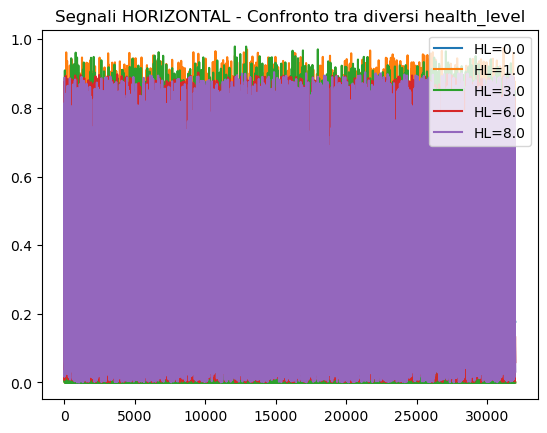

In [85]:
import matplotlib.pyplot as plt

# Prendi 5 sample casuali con health_level diversi
samples = df_filtered.sort_values('health_level').iloc[[0, len(df_filtered)//4, len(df_filtered)//2, 3*len(df_filtered)//4, -1]]

for i, row in samples.iterrows():
    plt.plot(row['horizontal_acceleration'], label=f'HL={row["health_level"]:.1f}')
plt.title("Segnali HORIZONTAL - Confronto tra diversi health_level")
plt.legend()
plt.show()


In [86]:
for i, row in samples.iterrows():
    raw = row['horizontal_acceleration']
    print(f"HL={row['health_level']:.1f} - Varianza: {np.var(raw):.6f} - Min: {np.min(raw):.4f} - Max: {np.max(raw):.4f}")


HL=0.0 - Varianza: 0.000000 - Min: 0.1768 - Max: 0.1768
HL=1.0 - Varianza: 0.028670 - Min: 0.0000 - Max: 0.9751
HL=3.0 - Varianza: 0.028617 - Min: 0.0000 - Max: 0.9792
HL=6.0 - Varianza: 0.021236 - Min: 0.0003 - Max: 0.9034
HL=8.0 - Varianza: 0.020815 - Min: 0.0001 - Max: 0.9044


## Testing

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc*100:.2f}%")

class_names = [0,1,2,3,4,5,6,7,8,9,10]  # Livelli di salute come classi per la regressione

# Predizioni
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Altro

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GearboxFaultDetector(nn.Module):
    """
    Modello multi-input per la diagnosi di fault nei gearbox.
    Gestisce segnali di vibrazione multi-assiali e condizioni operative variabili.
    """
    
    def __init__(self, input_length=61440, num_classes=11, confidence_output=True):
        super(GearboxFaultDetector, self).__init__()
        
        self.input_length = input_length
        self.num_classes = num_classes
        self.confidence_output = confidence_output
        
        # Encoder CNN per ogni asse di vibrazione
        self.horizontal_encoder = self._make_cnn_encoder()
        self.axial_encoder = self._make_cnn_encoder()
        self.vertical_encoder = self._make_cnn_encoder()
        
        # Encoder per il segnale tachometro
        self.tacho_encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=64, stride=8, padding=28),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(512)
        )
        
        # Encoder per condizioni operative (rpm, torque)
        self.operational_encoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        
        # Fusion layer
        fusion_input_dim = 512 * 3 + 512 + 128  # 3 assi + tacho + operational
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 1024),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.ReLU()
        )
        
        # Output heads
        self.health_classifier = nn.Linear(512, num_classes)
        
        if confidence_output:
            self.confidence_head = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid()  # Output tra 0 e 1
            )
    
    def _make_cnn_encoder(self):
        """Crea un encoder CNN per i segnali di vibrazione"""
        return nn.Sequential(
            # Block 1
            nn.Conv1d(1, 64, kernel_size=64, stride=4, padding=30),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=32, stride=2, padding=15),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=16, stride=2, padding=7),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            # Block 4
            nn.Conv1d(256, 512, kernel_size=8, stride=2, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(512)
        )
    
    def forward(self, horizontal, axial, vertical, tachometer, rpm, torque):
        """
        Forward pass del modello
        
        Args:
            horizontal, axial, vertical: tensori (batch_size, input_length)
            tachometer: tensore (batch_size, input_length)
            rpm, torque: tensori (batch_size, 1)
        """
        batch_size = horizontal.size(0)
        
        # Reshape per CNN (add channel dimension)
        horizontal = horizontal.unsqueeze(1)  # (batch_size, 1, input_length)
        axial = axial.unsqueeze(1)
        vertical = vertical.unsqueeze(1)
        tachometer = tachometer.unsqueeze(1)
        
        # Encode vibration signals
        h_feat = self.horizontal_encoder(horizontal)  # (batch_size, 512, 512)
        a_feat = self.axial_encoder(axial)
        v_feat = self.vertical_encoder(vertical)
        
        # Encode tachometer
        t_feat = self.tacho_encoder(tachometer)
        
        # Flatten spatial dimensions
        h_feat = h_feat.view(batch_size, -1)  # (batch_size, 512*512)
        a_feat = a_feat.view(batch_size, -1)
        v_feat = v_feat.view(batch_size, -1)
        t_feat = t_feat.view(batch_size, -1)
        
        # Encode operational conditions
        operational_conditions = torch.cat([rpm, torque], dim=1)  # (batch_size, 2)
        op_feat = self.operational_encoder(operational_conditions)
        
        # Fusion
        combined_features = torch.cat([h_feat, a_feat, v_feat, t_feat, op_feat], dim=1)
        fused_features = self.fusion(combined_features)
        
        # Output predictions
        health_logits = self.health_classifier(fused_features)
        health_probs = F.softmax(health_logits, dim=1)
        
        if self.confidence_output:
            confidence = self.confidence_head(fused_features)
            return health_probs, confidence
        else:
            return health_probs

class DataPreprocessor:
    """Classe per preprocessare i dati del dataset gearbox"""
    
    def __init__(self, target_length=61440, overlap=0.5):
        self.target_length = target_length
        self.overlap = overlap
    
    def extract_segments(self, signal):
        """Estrae segmenti di lunghezza fissa da segnale variabile"""
        if len(signal) < self.target_length:
            # Padding per segnali troppo corti
            padding = self.target_length - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')
            return [signal]
        
        segments = []
        step = int(self.target_length * (1 - self.overlap))
        
        for i in range(0, len(signal) - self.target_length + 1, step):
            segments.append(signal[i:i + self.target_length])
        
        return segments
    
    def normalize_signal(self, signal, method='standardize'):
        """Normalizza il segnale"""
        if method == 'standardize':
            return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)
        elif method == 'minmax':
            min_val, max_val = np.min(signal), np.max(signal)
            return (signal - min_val) / (max_val - min_val + 1e-8)
        return signal
    
    def prepare_dataset(self, df):
        """Prepara il dataset per il training"""
        X_horizontal, X_axial, X_vertical, X_tacho = [], [], [], []
        X_rpm, X_torque = [], []
        y_labels = []
        
        for _, row in df.iterrows():
            # Estrai segmenti da ogni segnale
            h_segments = self.extract_segments(row['horizontal_acceleration'])
            a_segments = self.extract_segments(row['axial_acceleration'])
            v_segments = self.extract_segments(row['vertical_acceleration'])
            t_segments = self.extract_segments(row['tachometer_signal'])
            
            # Assicurati che tutti abbiano lo stesso numero di segmenti
            min_segments = min(len(h_segments), len(a_segments), 
                             len(v_segments), len(t_segments))
            
            for i in range(min_segments):
                X_horizontal.append(self.normalize_signal(h_segments[i]))
                X_axial.append(self.normalize_signal(a_segments[i]))
                X_vertical.append(self.normalize_signal(v_segments[i]))
                X_tacho.append(self.normalize_signal(t_segments[i]))
                
                X_rpm.append(row['velocita'])
                X_torque.append(row['torque'])
                y_labels.append(row['health_level'])
        
        return {
            'horizontal': np.array(X_horizontal),
            'axial': np.array(X_axial),
            'vertical': np.array(X_vertical),
            'tachometer': np.array(X_tacho),
            'rpm': np.array(X_rpm).reshape(-1, 1),
            'torque': np.array(X_torque).reshape(-1, 1),
            'labels': np.array(y_labels)
        }

# Esempio di utilizzo
def train_model(df_train):
    """Esempio di training del modello"""
    
    # Preprocessa i dati
    preprocessor = DataPreprocessor(target_length=61440, overlap=0.5)
    data = preprocessor.prepare_dataset(df_train)
    
    # Inizializza il modello
    model = GearboxFaultDetector(
        input_length=61440, 
        num_classes=11, 
        confidence_output=True
    )
    
    # Setup training
    criterion_class = nn.CrossEntropyLoss()
    criterion_conf = nn.MSELoss()  # Per la confidenza
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Convert to tensors
    h_tensor = torch.FloatTensor(data['horizontal'])
    a_tensor = torch.FloatTensor(data['axial'])
    v_tensor = torch.FloatTensor(data['vertical'])
    t_tensor = torch.FloatTensor(data['tachometer'])
    rpm_tensor = torch.FloatTensor(data['rpm'])
    torque_tensor = torch.FloatTensor(data['torque'])
    labels_tensor = torch.LongTensor(data['labels'])
    
    print(f"Dataset preparato: {len(data['labels'])} campioni")
    print(f"Forme tensori - H:{h_tensor.shape}, A:{a_tensor.shape}, V:{v_tensor.shape}")
    
    return model, (h_tensor, a_tensor, v_tensor, t_tensor, rpm_tensor, torque_tensor, labels_tensor)

In [21]:
train_model(df_preprocessed)

Dataset preparato: 2016 campioni
Forme tensori - H:torch.Size([2016, 61440]), A:torch.Size([2016, 61440]), V:torch.Size([2016, 61440])


(GearboxFaultDetector(
   (horizontal_encoder): Sequential(
     (0): Conv1d(1, 64, kernel_size=(64,), stride=(4,), padding=(30,))
     (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
     (4): Conv1d(64, 128, kernel_size=(32,), stride=(2,), padding=(15,))
     (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
     (8): Conv1d(128, 256, kernel_size=(16,), stride=(2,), padding=(7,))
     (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (10): ReLU()
     (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
     (12): Conv1d(256, 512, kernel_size=(8,), stride=(2,), padding=(3,))
     (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, trac